In [66]:
from __future__ import division
import numpy as np
import glob
import matplotlib.pyplot as plt
import cPickle as pickle
import scipy.linalg as sl
import scipy.special as ss

import enterprise
from enterprise.signals import parameter
from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise.signals import utils

from tests.enterprise_test_data import datadir

import libstempo as t2

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from corner import corner, quantile

% matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Utility functions

In [67]:
class JumpProposal(object):
    
    def __init__(self, pta):
        """Set up some custom jump proposals
        
        :param params: A list of `enterprise` parameters
        
        """
        self.params = pta.params
        self.npar = len(pta.params)
        self.ndim = sum(p.size or 1 for p in pta.params)
        
        # parameter map
        self.pmap = {}
        ct = 0
        for p in pta.params:
            size = p.size or 1
            self.pmap[p] = slice(ct, ct+size)
            ct += size
            
        # parameter indices map
        self.pimap = {}
        for ct, p in enumerate(pta.param_names):
            self.pimap[p] = ct
            
        self.snames = {}
        for sc in pta._signalcollections:
            for signal in sc._signals:
                self.snames[signal.signal_name] = signal.params
        
    def draw_from_prior(self, x, iter, beta):
        """Prior draw.
        
        The function signature is specific to PTMCMCSampler.
        """
        
        q = x.copy()
        lqxy = 0
        
        # randomly choose parameter
        idx = np.random.randint(0, self.npar)
        
        # if vector parameter jump in random component
        param = self.params[idx]
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[param]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[idx] = param.sample()
        
        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[param]]) - param.get_logpdf(q[self.pmap[param]])
                
        return q, float(lqxy)
    
# utility function for finding global parameters
def get_global_parameters(pta):
    pars = []
    for sc in pta._signalcollections:
        pars.extend(sc.param_names)
    
    gpars = np.unique(filter(lambda x: pars.count(x)>1, pars))
    ipars = np.array([p for p in pars if p not in gpars])
        
    return gpars, ipars

# utility function to get parameter groupings for sampling
def get_parameter_groups(pta):
    ndim = len(pta.param_names)
    groups  = [range(0, ndim)]
    params = pta.param_names
    
    # get global and individual parameters
    gpars, ipars = get_global_parameters(pta)
    if any(gpars):
        groups.extend([[params.index(gp) for gp in gpars]])

    for sc in pta._signalcollections:
        for signal in sc._signals:
            ind = [params.index(p) for p in signal.param_names if p not in gpars]
            if ind:
                groups.extend([ind])
    
    return groups

## Read in pulsar data

In [70]:
psr = Pulsar('partim/J0437-4715.par', 'partim/J0437-4715.tim')

<Container object of 3 artists>

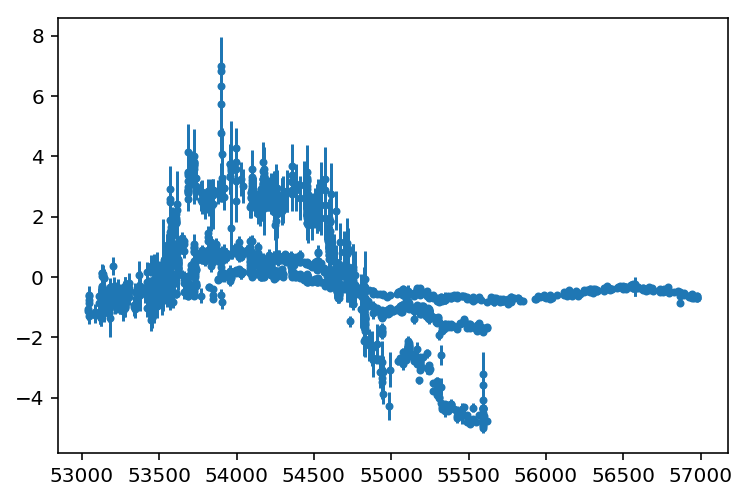

In [71]:
plt.errorbar(psr.toas/86400, psr.residuals*1e6, psr.toaerrs*1e6, fmt='.')

## Setup model

We will add some addition model components that are not part of the base enterprise

### 1. Exponential decay function to model "void" in J1713+0747

In [72]:
@signal_base.function
def exp_decay(toas, freqs, log10_Amp=-7, t0=54000, log10_tau=1.7):
    t0 *= const.day
    tau = 10**log10_tau * const.day
    wf = - 10**log10_Amp * np.heaviside(toas-t0, 1) * np.exp(-(toas-t0)/tau)
    return wf * (1400/freqs)**2

### 2. Yearly DM sinusoid

In [73]:
@signal_base.function
def yearly_sinusoid(toas, freqs, log10_Amp=-7, phase=0):

    wf = 10**log10_Amp * np.sin(2*np.pi*const.fyr*toas+phase)
    return wf * (1400/freqs)**2

@signal_base.function
def yearly_sinusoid_basis(toas, freqs):
    
    F = np.zeros((len(toas), 2))
    F[:,0] = np.sin(2*np.pi*toas*const.fyr)
    F[:,1] = np.cos(2*np.pi*toas*const.fyr)
    
    Dm = (1400/freqs)**2

    return F * Dm[:, None], np.repeat(const.fyr, 2)

@signal_base.function
def yearly_sinusoid_prior(f):
    return np.ones(len(f)) * 1e20

### 3. DM EQUAD (EQUAD) term that scales like $\nu^{-4}$ (variance remember...)

In [74]:
# define DM EQUAD variance function
@signal_base.function
def dmequad_ndiag(freqs, log10_dmequad=-8):
    return np.ones_like(freqs) * (1400/freqs)**4 * 10**(2*log10_dmequad)

### 4. SVD timing model basis
This allows for more stability over standard scaling methods

In [75]:
# SVD timing model basis
@signal_base.function
def svd_tm_basis(Mmat):
    u, s, v = np.linalg.svd(Mmat, full_matrices=False)
    return u, np.ones_like(s)

@signal_base.function
def tm_prior(weights):
    return weights * 10**40

In [215]:
# define selection by observing backend
selection1 = selections.Selection(selections.by_backend)

# special selection for ECORR only use wideband NANOGrav data
selection2 = selections.Selection(selections.nanograv_backends)

# white noise parameters
#efac = parameter.Uniform(0.5, 10.0)
efac = parameter.Normal(1.0, 0.1)
equad = parameter.Uniform(-10, -4)
ecorr = parameter.Uniform(-10, -4)

# red noise and DM parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# DM turnover parameters
kappa = parameter.Uniform(0,7)
lf0 = parameter.Uniform(-9, -6.5)

# DM exponential parameters
t0 = parameter.Uniform(psr.toas.min()/86400, psr.toas.max()/86400)
log10_Amp = parameter.Uniform(-10, -2)
log10_tau = parameter.Uniform(np.log10(5), np.log10(500))

# DM EQUAD
dmvariance = dmequad_ndiag(log10_dmequad=equad)
dmeq = white_signals.WhiteNoise(dmvariance)

# white noise signals
ef = white_signals.MeasurementNoise(efac=efac, selection=selection1)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection1)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection2)

# red noise signal
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(pl, components=30)

# DM GP signals (use turnover model for more flexibility)
dm_basis = utils.createfourierdesignmatrix_dm(nmodes=30)
dm_prior = utils.turnover(log10_A=log10_A, gamma=gamma, lf0=lf0, kappa=kappa)
dmgp = gp_signals.BasisGP(dm_prior, dm_basis, name='dm')

# DM exponential model
wf = exp_decay(log10_Amp=log10_Amp, t0=t0, log10_tau=log10_tau)
dmexp = deterministic_signals.Deterministic(wf, name='exp')

# DM sinusoid model
ys_prior = yearly_sinusoid_prior()
ys_basis = yearly_sinusoid_basis()
dmys = gp_signals.BasisGP(ys_prior, ys_basis, name='s1yr')

# timing model
basis = svd_tm_basis()
prior = tm_prior()
#tm = gp_signals.BasisGP(prior, basis)
tm = gp_signals.TimingModel()

# full model
s = ef + eq + rn + dmgp + tm + dmys
if 'NANOGrav' in psr.flags['pta']:
    s += ec
if psr.name == 'J1713+0747':
    s += dmexp

# set up PTA of one
pta = signal_base.PTA([s(psr)])


In [200]:
pta.param_names

[u'J0437-4715_CPSR2_20CM_efac',
 u'J0437-4715_CPSR2_20CM_log10_equad',
 u'J0437-4715_CPSR2_40CM_efac',
 u'J0437-4715_CPSR2_40CM_log10_equad',
 u'J0437-4715_CPSR2_50CM_efac',
 u'J0437-4715_CPSR2_50CM_log10_equad',
 u'J0437-4715_PDFB_10CM_efac',
 u'J0437-4715_PDFB_10CM_log10_equad',
 u'J0437-4715_PDFB_20CM_efac',
 u'J0437-4715_PDFB_20CM_log10_equad',
 u'J0437-4715_PDFB_40CM_efac',
 u'J0437-4715_PDFB_40CM_log10_equad',
 u'J0437-4715_PDFB_50CM_efac',
 u'J0437-4715_PDFB_50CM_log10_equad',
 u'J0437-4715_WBCORR_10CM_efac',
 u'J0437-4715_WBCORR_10CM_log10_equad',
 u'J0437-4715_WBCORR_20CM_efac',
 u'J0437-4715_WBCORR_20CM_log10_equad',
 u'J0437-4715_dm_gamma',
 u'J0437-4715_dm_kappa',
 u'J0437-4715_dm_lf0',
 u'J0437-4715_dm_log10_A',
 u'J0437-4715_gamma',
 u'J0437-4715_log10_A',
 u'J0437-4715_log10_dmequad',
 u'J0437-4715_s1yr_log10_Amp',
 u'J0437-4715_s1yr_phase']

In [123]:
# check likelihood timing
%timeit params = {p.name: p.sample() for p in pta.params}; pta.get_lnlikelihood(params)

The slowest run took 4.57 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 6.21 ms per loop


In [124]:
# dimension of parameter space
x0 = np.hstack(p.sample() for p in pta.params)
ndim = len(x0)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1**2)

## change initial jump size for tau
#idx = pta.param_names.index('J1713+0747_exp_t0')
#cov[idx, idx] = 100

# parameter groupings
groups = get_parameter_groups(pta)

outdir = 'chains/J0437-4715_tm_efac_norm/'
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, 
                 outDir=outdir, resume=True)
np.savetxt(outdir+'/pars.txt', map(str, pta.param_names), fmt='%s')

# add prior draw to proposal cycle
jp = JumpProposal(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 15)

/Users/jaellis/.virtualenvs/enterprise/lib/python2.7/site-packages/ipykernel_launcher.py:65: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/jaellis/.virtualenvs/enterprise/lib/python2.7/site-packages/ipykernel_launcher.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [125]:
N = 1000000
sampler.sample(x0, N, SCAMweight=35, AMweight=10, DEweight=50)

Finished 1.00 percent in 55.741809 s Acceptance rate = 0.352778Adding DE jump with weight 50
Finished 15.20 percent in 824.895191 s Acceptance rate = 0.385678

KeyboardInterrupt: 

In [216]:
#chain = np.loadtxt('chains/J1713+0747_standard/chain_1.txt')
#burn = int(0.25*chain.shape[0])

chain = np.loadtxt('chains/J0437-4715/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = pta.param_names

chain2 = np.loadtxt('chains/J0437-4715_tm/chain_1.txt')
burn2 = int(0.25*chain2.shape[0])

In [217]:
def get_dm_model(psr, pta, chain, tm_svd=False):
    
    wave = 0
    
    # get parameter dictionary
    ind = np.random.randint(burn, chain.shape[0])
    params = {par.name: chain[ind, ct] for ct, par in enumerate(pta.params)}
    
    # deterministic signal part
    wave += pta.get_delay(params=params)[0]
    
    # get linear parameters
    Nvec = pta.get_ndiag(params)[0]
    phiinv = pta.get_phiinv(params, logdet=False)[0]
    T = pta.get_basis(params)[0]

    d = pta.get_TNr(params)[0]
    TNT = pta.get_TNT(params)[0]

    # Red noise piece
    Sigma = TNT + np.diag(phiinv)

    try:
        u, s, _ = sl.svd(Sigma)
        mn = np.dot(u, np.dot(u.T, d)/s)
        Li = u * np.sqrt(1/s)
    except np.linalg.LinAlgError:
        print 'here'
        Q, R = sl.qr(Sigma)
        Sigi = sl.solve(R, Q.T)
        mn = np.dot(Sigi, d)
        u, s, _ = sl.svd(Sigi)
        Li = u * np.sqrt(s)

    b = mn + np.dot(Li, np.random.randn(Li.shape[0]))
    
    # find basis indices
    pardict = {}
    for sc in pta._signalcollections:
        ntot = 0
        for sig in sc._signals:
            if sig.signal_type == 'basis':
                basis = sig.get_basis(params=params)
                nb = basis.shape[1]
                pardict[sig.signal_name] = np.arange(ntot, nb+ntot)
                ntot += nb
                
    
    # DM quadratic + GP
    key = 'linear timing model' if not tm_svd else ''
    dmind = np.array([ct for ct, p in enumerate(psr.fitpars) if 'DM' in p])[1:]
    idx = np.concatenate((pardict[key][dmind], pardict['dm']))
    
    # coordinate transform
    if tm_svd:
        u, s, v = np.linalg.svd(psr.Mmat, full_matrices=False)
        tmind = pardict[key]
        #b[tmind] = np.dot(v/s[:,None], b[tmind])
        #T[:, tmind] = psr.Mmat
    #wave += np.dot(T[:,idx], b[idx])
    wave += np.dot(T[:, pardict['dm']], b[pardict['dm']])
    
    return wave * (psr.freqs**2 * const.DM_K * 1e12) 

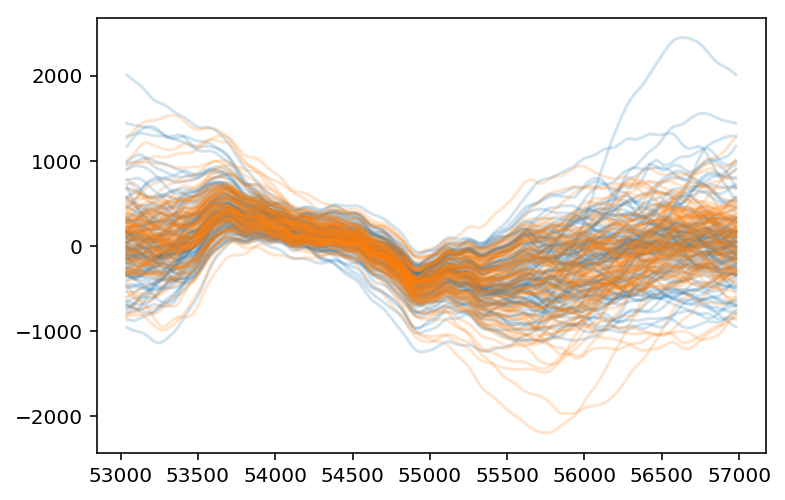

In [221]:
N = 100
for ii in range(N):
    dm = get_dm_model(psr, pta, chain, tm_svd=False)
    plt.plot(psr.toas/86400, (dm-dm.mean())*1e6, color='C0', alpha=0.2)
for ii in range(N):
    dm = get_dm_model(psr, pta, chain2, tm_svd=False)
    plt.plot(psr.toas/86400, (dm-dm.mean())*1e6, color='C1', alpha=0.2)

In [208]:
pardict = {}
for sc in pta._signalcollections:
    ntot = 0
    for sig in sc._signals:
        if sig.signal_type == 'basis':
            basis = sig.get_basis()
            nb = basis.shape[1]
            pardict[sig.signal_name] = np.arange(ntot, nb+ntot)
            ntot += nb

In [209]:
pardict

{u'': array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]),
 'dm': array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]),
 u'red noise': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59])}

In [100]:
len(pars)

27

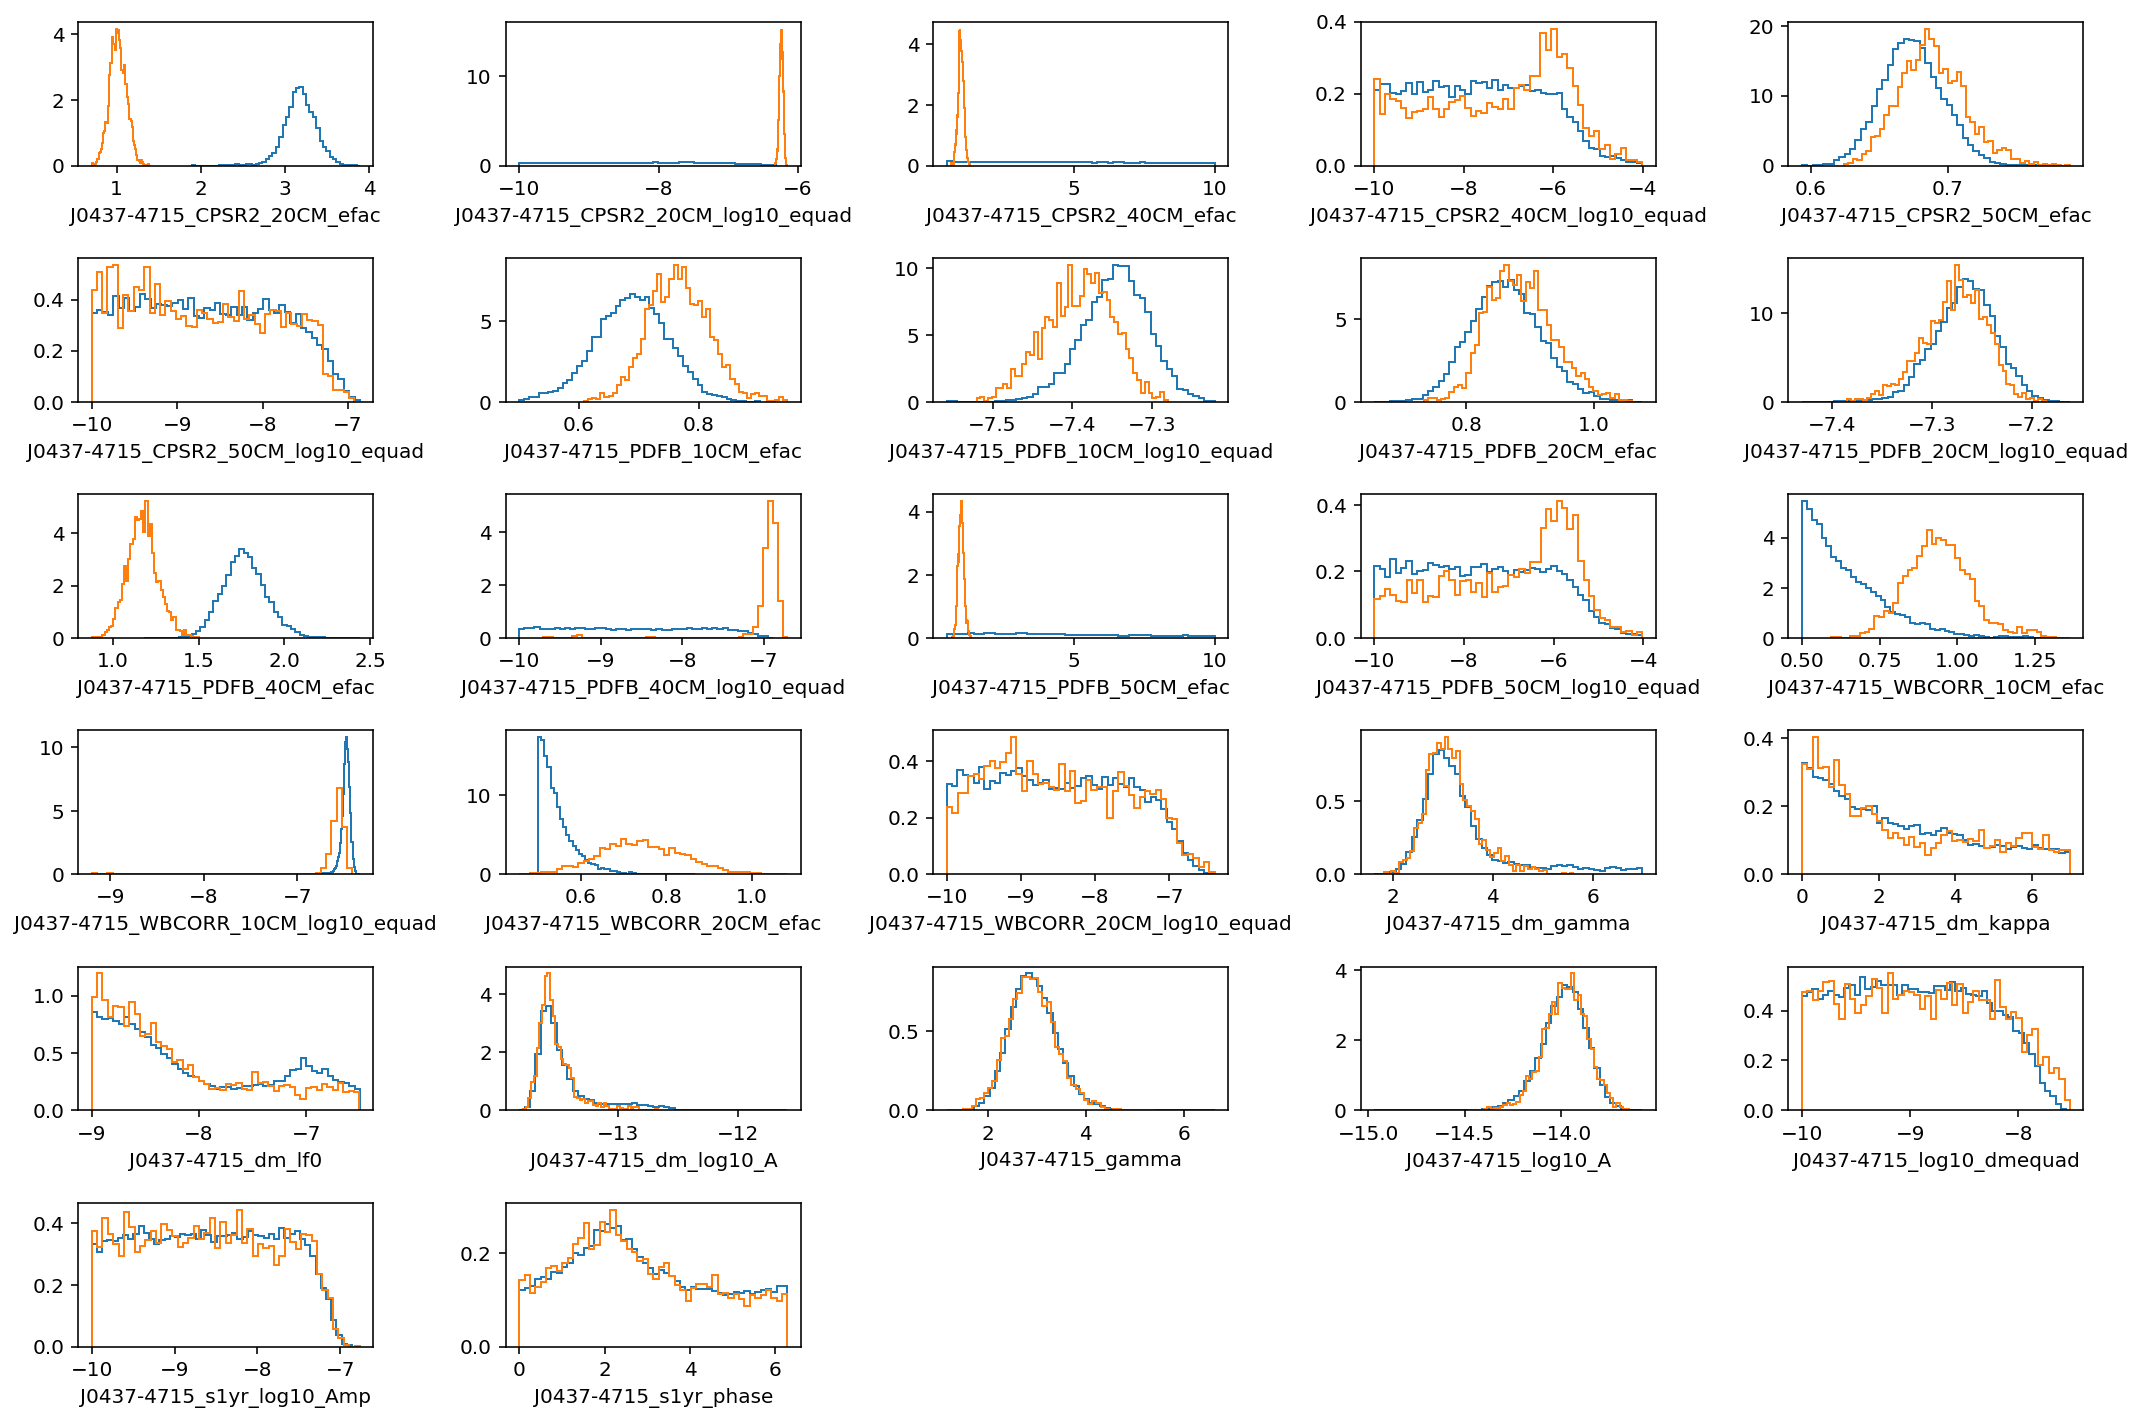

In [129]:
plt.figure(figsize=(15, 10))
for ii in range(27):
    plt.subplot(6,5,ii+1)
    plt.hist(chain[burn:, ii], 50, normed=True, histtype='step')
    plt.hist(chain2[burn2:, ii], 50, normed=True, histtype='step')
    plt.xlabel(pars[ii])
plt.tight_layout()

In [130]:
idx = np.array([ct for ct, p in enumerate(pars) if 'WBCORR_10CM' in p])

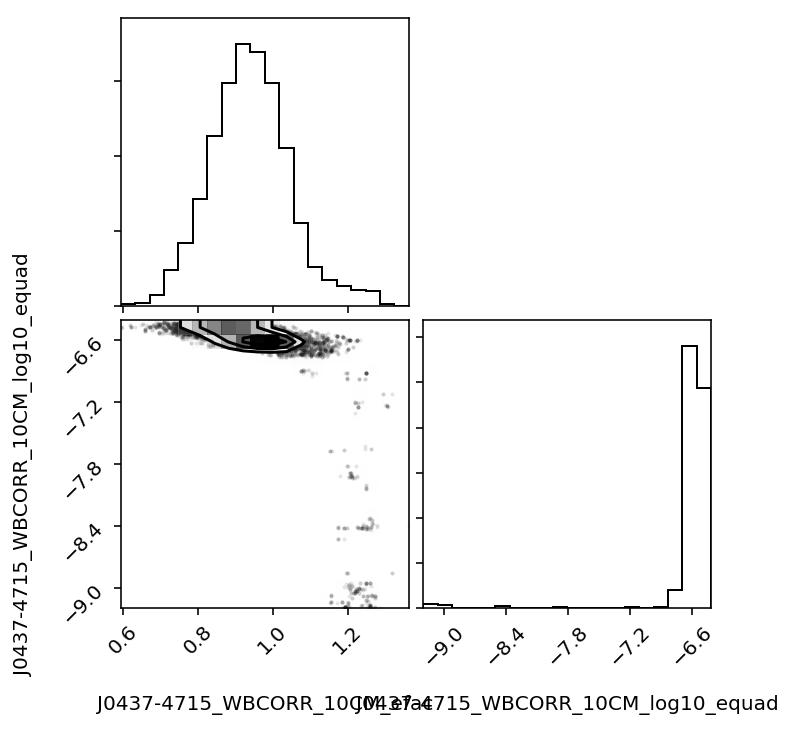

In [132]:
corner(chain2[burn2:, idx], labels=np.array(pars)[idx]);

In [228]:
uflags = np.unique(psr.backend_flags)
uflags = np.unique(psr.flags['group'])
for flag in uflags:
    print flag, sum(psr.backend_flags == flag)

CPSR2_20CM 215
CPSR2_40CM 1
CPSR2_50CM 570
PDFB_10CM 645
PDFB_20CM 668
PDFB_40CM 132
PDFB_50CM 1
WBCORR_10CM 193
WBCORR_20CM 30


In [227]:
sorted(psr.flags.keys())

['B',
 'be',
 'beconfig',
 'bw',
 'cpsr2_50cm',
 'cpsr2m_1341',
 'cpsr2n_1405',
 'dfb3_J0437_55319_56160',
 'f',
 'fe',
 'g',
 'gof',
 'group',
 'h',
 'j',
 'length',
 'pdfb1_128_ch',
 'pdfb1_512_ch',
 'pdfb1_post_2006',
 'pdfb1_pre_2006',
 'pdfb2_1024_MHz',
 'pdfb2_256MHz_1024_ch',
 'pdfb3_256MHz_1024ch',
 'pdfb3_64MHz_512ch',
 'pdfb4_2048_1024_1024',
 'pdfb4_256MHz_1024ch',
 'pdfb4_55319_56055_cals',
 'pdfb4_56055_56110_cals',
 'pdfb4_56110_56160_cals',
 'pdfb4_56160_60000_cals',
 'ppta_sql',
 'projid',
 'pta',
 'q',
 'snr',
 'tmplt',
 'tobs']

In [164]:
b / (a+1)

0.25